# Lab: Support Vector Machines (SVM) — dalla geometria alla pratica

In questo notebook costruiamo le SVM **come una storia unica**, collegando ogni pezzo di teoria a un comportamento osservabile nel codice.

## 🎯 Obiettivi del lab
Al termine sarai in grado di:

- interpretare un classificatore lineare come un **iperpiano** $f(x)=w^T x + b$ e leggere **segno**, **margine** e **distanze**;
- capire perché le SVM cercano la **massima separazione** (massimo margine) e perché questo porta a un problema **convesso**;
- passare da *hard margin* a *soft margin* tramite le variabili di slack $\xi_i$ e riconoscere la **hinge loss**;
- osservare in pratica il ruolo delle condizioni KKT: **pochi punti (support vectors) determinano la soluzione**;
- distinguere due modi di risolvere una SVM:
  - **primal** tramite (sub)gradient descent su hinge loss + regolarizzazione;
  - **duale**, necessario quando entrano in gioco i **kernel**.

> **Nota didattica importante**  
> - In questo notebook useremo il **batch subgradient descent**, non la versione completamente stocastica (SGD).  
> - `SVC` in scikit-learn risolve la SVM nel **duale**, ed è quindi la scelta naturale quando si usano i **kernel**.

---

## 🧭 Roadmap del notebook (teoria ↔ pratica)

1. **Geometria in 2D**  
   Iperpiano, lato di classificazione, margine funzionale e margine geometrico.

2. **Hard margin SVM**  
   Per dati separabili: perché minimizzare  
   $$\frac{1}{2}\|w\|^2$$  
   equivale a massimizzare il margine.

3. **Soft margin e slack variables**  
   Intuizione del compromesso imposto dal parametro $C$.

4. **Hinge loss**  
   $$L_H(x_i,t_i)=\max(0,\,1 - t_i(w^T x_i + b))$$  
   Perché non è derivabile e serve il *subgradient*.

5. **KKT in pratica**  
   Identificazione dei support vector tramite i margini funzionali.

6. **Kernel trick**  
   Sostituzione del prodotto scalare con $K(x_i,x_j)$ per ottenere separazioni non lineari.

---

## 📝 Convenzioni e notazione (coerenti con il corso)

- Dati: $\{(x_i,t_i)\}_{i=1}^n$ con $x_i \in \mathbb{R}^d$
- Etichette: $t_i \in \{-1,+1\}$
- Classificatore lineare:  
  $$f(x)=w^T x + b$$
  *(nota: alcune slide usano $w^T x - b$; è la stessa cosa cambiando il segno di $b$).*

- Predizione:  
  $$\hat{t}=\mathrm{sign}(f(x))$$

- Margine funzionale del punto:  
  $$m_i = t_i f(x_i)$$

---

## 🔎 Perché iniziamo in 2D?

La parte più importante delle SVM è **geometrica**:

- il confine è un iperpiano (in 2D: una retta),
- il margine misura “quanto siamo sicuri” delle decisioni,
- solo alcuni punti (sul margine o dentro di esso) influenzano la soluzione ottima.

Per questo la prima parte del lab usa dataset sintetici 2D, in modo da **vedere con gli occhi ciò che la teoria descrive**.  
Una volta acquisita l’intuizione, passeremo al caso generale.

# 1. Geometria del classificatore lineare  
*(Siamo nel **primale**, come definito nel corso)*

Prima di introdurre margini, slack o kernel, fissiamo la struttura fondamentale della SVM:  
una **SVM è, nel primale, un classificatore lineare**.  
Tutto ciò che verrà dopo — margini, hinge loss, support vector, kernel — nasce da questa geometria semplice.

---

## 1.1 L’iperpiano di decisione

Nel primale, una SVM apprende una funzione lineare del tipo:

$$
f(x) = w^T x + b
$$

dove:

- $w \in \mathbb{R}^d$ è il vettore dei pesi,
- $b \in \mathbb{R}$ è il bias (intercetta),
- il **segno** di $f(x)$ determina la classe predetta.

In 2D ($d=2$), l’iperpiano diventa semplicemente una **retta**:

- $f(x)=0$ → frontiera di decisione  
- $f(x)>0$ → classe positiva  
- $f(x)<0$ → classe negativa  

Questa è la base geometrica di tutto il modello.

---

## 1.2 Come il modello classifica: il margine funzionale

Dato un punto $(x_i,t_i)$ con etichetta $t_i \in \{-1,+1\}$:

- se $t_i f(x_i) > 0$ → **corretto**  
- se $t_i f(x_i) < 0$ → **errore di classificazione**  
- se $t_i f(x_i) = 0$ → esattamente sull’iperpiano

La quantità:

$$
t_i f(x_i)
$$

è chiamata **margine funzionale** del punto.

È una misura di:
- correttezza della classificazione,
- “quanto” il punto sta dal lato giusto.

---

## 1.3 La distanza geometrica dall’iperpiano

La distanza vera e propria di un punto $x_i$ dall’iperpiano $f(x)=0$ è:

$$
\mathrm{dist}(x_i, \text{iperpiano})
=
\frac{|w^T x_i + b|}{\|w\|}
$$

Perché il denominatore $\|w\|$?

- $|w^T x + b|$ misura quanto forte il modello “risponde” al punto,  
- ma un modello con $w$ molto grande può dare valori grandi anche a punti vicini.

Dividendo per $\|w\|$ otteniamo una vera **distanza euclidea**.

---

## 1.4 Perché il margine è cruciale?

Supponiamo che esistano molti iperpiani che separano correttamente le due classi.  
Quale scegliamo?

Le SVM scelgono quello con **margine più grande**, cioè quello che massimizza la distanza minima dei punti dal confine.

Intuizione:

- un margine grande = decisioni più sicure,  
- meno sensibile al rumore,  
- meno rischio di overfitting *lineare* (iperpiani troppo inclinati per inseguire outlier).

---

## 1.5 La normalizzazione: i punti più vicini hanno margine 1

Per i punti più vicini all’iperpiano (i futuri “support vector”), imponiamo:

$$
t_i(w^T x_i + b) = 1
$$

Con questa normalizzazione, la distanza minima fra i punti e l’iperpiano è:

$$
\text{margine} = \frac{1}{\|w\|}
$$

Questa scelta è fondamentale perché:

- semplifica i vincoli del problema di ottimizzazione,
- trasforma la massimizzazione del margine nella minimizzazione di $\|w\|$.

---

## 1.6 Il problema fondamentale (hard margin, primale)

Ora possiamo scrivere formalmente il problema SVM per dati separabili:

$$
\min_{w,b} \frac12 \|w\|^2
\quad\text{s.t.}\quad
t_i(w^T x_i + b) \ge 1 \quad \forall i
$$

Interpretazione:

- il termine $\frac12\|w\|^2$ vuole rendere il margine grande,
- il vincolo $t_i f(x_i) \ge 1$ assicura che tutti i punti stiano **fuori** dal margine.

Questa è la formulazione **primale hard margin**: il punto da cui nasce tutta la teoria SVM.

---

### ➤ Takeaway

- Nel primale, una SVM è un semplice iperpiano $f(x)=w^Tx+b$.
- La classificazione dipende solo dal **segno** di $f(x)$.
- La quantità più importante è $t_i f(x_i)$: il **margine funzionale**.
- Il margine geometrico è $1/\|w\|$:  
  **minimizzare $\|w\|$ = massimizzare il margine**.
- Tutta la teoria successiva (slack, hinge loss, KKT, kernel) nasce da questa geometria.

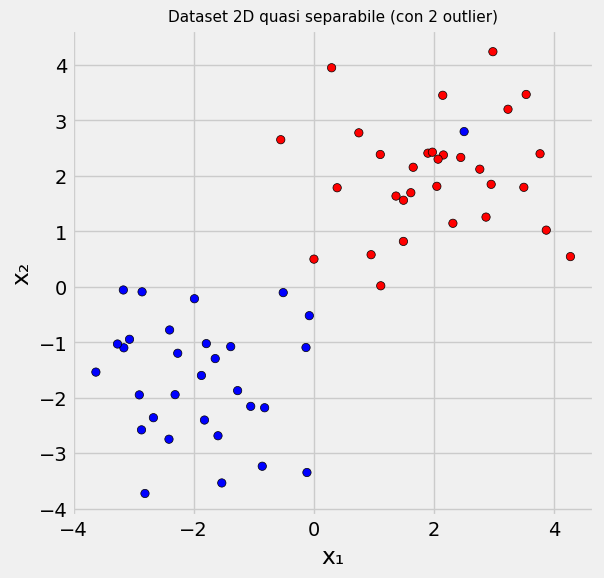

In [ ]:
# ============================================
# 1) Setup iniziale per SVM in 2D
# ============================================
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (6, 6)

def plot_points(X, y):
    """Plot semplice dei punti in 2D con colori ±1."""
    plt.scatter(X[:,0], X[:,1], c=y, cmap="bwr", edgecolor='k')
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.grid(True)

# ============================================
# 2) Generiamo un dataset 2D quasi separabile (toy)
# ============================================
# Obiettivo didattico:
# - le due classi sono *quasi* separabili
# - aggiungiamo 1–2 punti "sporchi" per introdurre la soft margin

np.random.seed(0)

# Due gaussiane ben separate
N = 30
X_pos = np.random.randn(N, 2) + np.array([2, 2])
X_neg = np.random.randn(N, 2) + np.array([-2, -2])

# Aggiungiamo 2 punti sporchi
outliers_pos = np.array([[0.0, 0.5]])     # punto positivo vicino ai negativi
outliers_neg = np.array([[2.5, 2.8]])     # punto negativo vicino ai positivi

X = np.vstack([X_pos, X_neg, outliers_pos, outliers_neg])
y = np.hstack([ np.ones(N), -np.ones(N),  +1, -1 ])

# Plot finale
plt.figure()
plot_points(X, y)
plt.title("Dataset 2D quasi separabile (con 2 outlier)", fontsize=11)
plt.show()

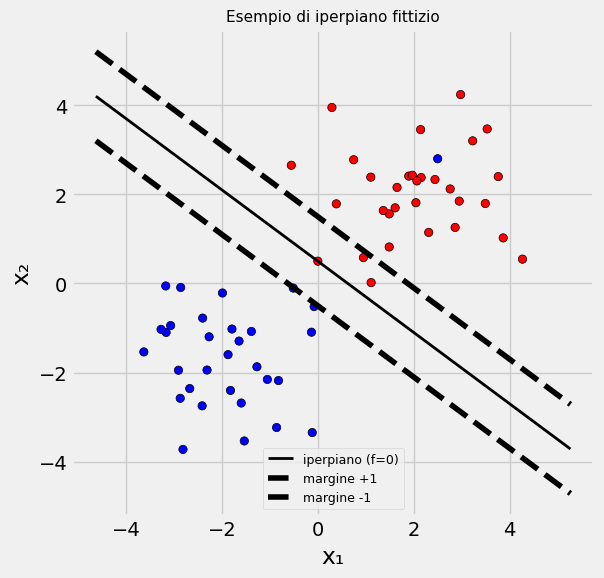

In [ ]:
# ============================================
# 3) Funzioni utili per classificatore lineare
# ============================================

def f(x, w, b):
    """
    Valuta il classificatore lineare f(x)=w^T x + b.
    Accetta sia un singolo punto x (shape: (2,))
    sia una matrice di punti X (shape: (n,2)).
    """
    return x @ w + b


def plot_hyperplane(w, b, X, y, title=None):
    """
    Disegna:
    - i punti (colorati per classe)
    - l'iperpiano f(x)=0
    - i due margini f(x)=±1

    CREA una nuova figura, così ogni chiamata è indipendente.
    """
    plt.figure(figsize=(6, 6))
    plot_points(X, y)

    # Range assi
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    xs = np.linspace(x_min, x_max, 400)

    # Caso quasi-verticale
    if abs(w[1]) < 1e-8:
        x0 = -b / (w[0] + 1e-12)
        plt.axvline(x0, color='k', linewidth=2, label='iperpiano (f=0)')
        plt.axvline(x0 - 1/np.linalg.norm(w), color='k', linestyle='--')
        plt.axvline(x0 + 1/np.linalg.norm(w), color='k', linestyle='--')
    else:
        ys = -(w[0]*xs + b) / w[1]
        ys_pos = -(w[0]*xs + b - 1) / w[1]
        ys_neg = -(w[0]*xs + b + 1) / w[1]

        plt.plot(xs, ys, 'k', linewidth=2, label='iperpiano (f=0)')
        plt.plot(xs, ys_pos, 'k--', label='margine +1')
        plt.plot(xs, ys_neg, 'k--', label='margine -1')

    plt.legend(fontsize=9)
    plt.title(title if title else "Iperpiano e margini", fontsize=11)

# ============================================
# 4) Esempio di iperpiano "fittizio"
# (solo per visualizzare geometria)
# ============================================

w = np.array([0.8, 1.0])
b = -0.5

plot_hyperplane(w, b, X, y, title="Esempio di iperpiano fittizio")
plt.show()

# 2. Dall’hard margin al soft margin: quando i dati **non** sono separabili

Finora abbiamo lavorato nel caso ideale: due classi separabili perfettamente da un iperpiano.  
In questo scenario (quasi mai realistico) l’SVM cerca l’iperpiano con **margine massimo**:

$$
\min_{w,b} \frac12 \|w\|^2
\quad\text{s.t.}\quad
t_i(w^T x_i+b) \ge 1 \quad \forall i.
$$

Ma nella pratica quasi sempre ci sono:
- **rumore** nei dati,
- **outliers**,
- **regioni sovrapposte** tra le classi.

In questi casi i vincoli non possono essere soddisfatti per tutti gli \(i\).  
Serve quindi un modo per “perdonare” alcune violazioni.

---

# 2.1 Soft margin SVM: introdurre la tolleranza tramite le *slack variables*

Per consentire violazioni controllate dei vincoli, introduciamo variabili di slack:

- $\xi_i = 0$: il punto è ben classificato e **fuori** dal margine  
- $0 < \xi_i < 1$: il punto è nel margine, ma dalla parte corretta  
- $\xi_i > 1$: il punto è **misclassificato**

Il nuovo problema di ottimizzazione (primale) diventa:

$$
\min_{w,b,\xi} \quad \frac12\|w\|^2 + C \sum_{i=1}^n \xi_i
$$

$$
\text{s.t.} \quad
t_i(w^T x_i + b) \ge 1 - \xi_i,
\qquad
\xi_i \ge 0.
$$

Il parametro \(C > 0\) controlla il compromesso tra:
- **ampiezza del margine** (minimizzare \(\|w\|\))  
- **numero e gravità delle violazioni** (penalizzate tramite \(\xi_i\))

Interpretazione operativa:

- **C grande** → tollero poco gli errori → margine più stretto  
- **C piccolo** → modello più robusto al rumore → margine più largo

---

# 2.2 Eliminare le slack: nasce la **hinge loss**

Dai vincoli:

$$
\xi_i = \max\big(0,\; 1 - t_i(w^T x_i + b)\big)
$$

Sostituendo nel primale si ottiene un problema **senza vincoli**, con la funzione obiettivo:

$$
J(w,b)
=
\frac12\|w\|^2
+
C \sum_{i=1}^n
\max\big(0,\; 1 - t_i f(x_i)\big).
$$

La funzione

$$
L_H(x_i,t_i) = \max(0,\; 1 - t_i f(x_i))
$$

è la **hinge loss**.  
Penalizza solo i punti:
- dentro il margine $t_i f(x_i) < 1$
- o misclassificati $t_i f(x_i) < 0$

mentre **ignora** quelli ben lontani dal margine.

Geometricamente: l’SVM “si concentra solo sui punti che contano”.

---

# 3. Subgradient descent nel primale

La hinge loss non è derivabile in $1 - t_i f(x_i)=0$, ma è *subdifferenziabile*.  
Il subgradiente dell’obiettivo rispetto a \(w\) è:

$$
\nabla_w J(w)
=
w \;-\;
C \sum_{i:\; t_i f(x_i) < 1}
t_i x_i.
$$

Analogamente, il subgradiente rispetto a \(b\) è:

$$
\nabla_b J(b)
=
- C \sum_{i:\; t_i f(x_i) < 1} t_i.
$$

Interpretazione:

- Se un punto è **ben classificato** e **fuori dal margine**  
  ($t_i f(x_i) > 1$),  
  ⇒ **non contribuisce** al gradiente (solo regolarizzazione).

- Se un punto è **dentro il margine** o **misclassificato**,  
  ⇒ “tira” \(w\) e \(b\) nella direzione corretta.

L’update del subgradient descent è:

$$
w^{(r+1)} = w^{(r)} - \eta\, \nabla_w J(w^{(r)}),
$$

$$
b^{(r+1)} = b^{(r)} - \eta\, \nabla_b J(b^{(r)}).
$$

Questa è la base di ottimizzatori moderni come **PEGASOS**, usati in pratica per SVM lineari su dataset molto grandi.

---

epoch    0 | loss=192.1029 | ||w||=16.166
epoch  500 | loss=7.1511 | ||w||=0.793
epoch 1000 | loss=7.1511 | ||w||=0.793
epoch 1500 | loss=7.1511 | ||w||=0.793
epoch 2000 | loss=7.1511 | ||w||=0.793
epoch 2500 | loss=7.1511 | ||w||=0.793


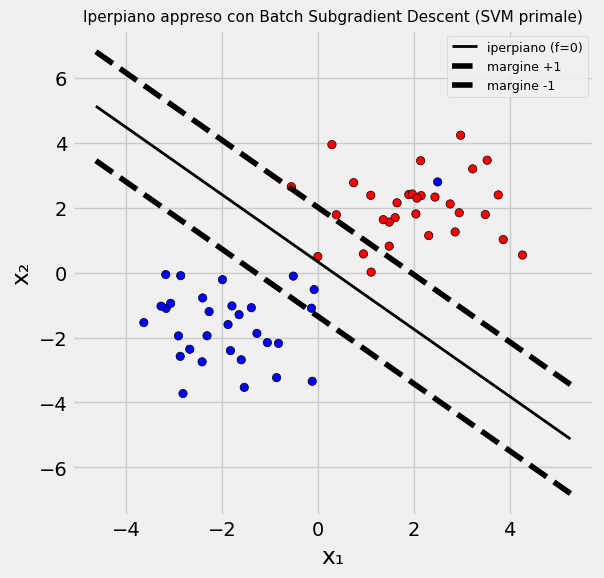

In [ ]:
# ============================================
# 5) Hinge loss e *Batch* Subgradient Descent (primal)
# ============================================

def hinge_loss(w, b, X, y):
    """
    Calcola la hinge loss totale:
        L = Σ_i max(0, 1 - t_i (w^T x_i + b))
    """
    margins = y * (X @ w + b)
    return np.maximum(0, 1 - margins).sum()


def subgradient(w, b, X, y, C):
    """
    Subgradiente batch di:
        J(w,b) = 1/2 ||w||^2 + C Σ hinge
    Restituisce (grad_w, grad_b).
    """
    margins = y * (X @ w + b)

    # Punti che violano il margine: t_i f(x_i) < 1
    idx = (margins < 1)

    # Parte dalla regolarizzazione: ∂/∂w (1/2 ||w||^2) = w
    grad_w = w.copy()
    grad_b = 0.0

    # Parte dalla hinge loss
    if np.any(idx):
        grad_w -= C * (y[idx, None] * X[idx]).sum(axis=0)
        grad_b -= C * y[idx].sum()

    return grad_w, grad_b


# ============================================
# 6) Batch Subgradient Descent per SVM (primal)
# ============================================

def train_svm_batch_subgradient(X, y, C=1.0, lr=0.001, epochs=3000):
    """
    Ottimizzazione *batch* della SVM nel primale.
    Ad ogni iterazione usa *tutti* i punti per il subgradiente.
    """
    w = np.zeros(X.shape[1])
    b = 0.0

    for t in range(epochs):
        grad_w, grad_b = subgradient(w, b, X, y, C)

        w -= lr * grad_w
        b -= lr * grad_b

        if t % 500 == 0:
            loss = 0.5*np.dot(w, w) + C * hinge_loss(w, b, X, y)
            print(f"epoch {t:4d} | loss={loss:.4f} | ||w||={np.linalg.norm(w):.3f}")

    return w, b


# ============================================
# 7) Addestramento
# ============================================

w_svm, b_svm = train_svm_batch_subgradient(X, y, C=1.0, lr=0.1, epochs=3000)

# Plot con figura nuova (gestita da plot_hyperplane)
plot_hyperplane(w_svm, b_svm, X, y,
                title="Iperpiano appreso con Batch Subgradient Descent (SVM primale)")
plt.show()

## 🔍 Cosa sta succedendo quando cambio C?

Il parametro **C** controlla il trade-off tra:

- **grande margine** (piccola norma di w → confine morbido)
- **pochi errori / violazioni** (hinge loss piccola → confine più rigido)

### 🔹 C piccolo (es. C = 0.1)
- La penalizzazione sugli errori è bassa.
- Il modello preferisce aumentare il margine (ridurre ||w||).
- La decision boundary è **più morbida**, tende a ignorare outlier.

### 🔹 C grande (es. C = 10, 100)
- Le violazioni del margine costano molto.
- L’algoritmo “spinge” per separare *quasi perfettamente* i dati.
- Il margine diventa **più stretto**, ||w|| aumenta.
- I punti sporchi/outlier influenzano molto il confine.

### 📌 In sintesi
- **C basso → modello più robusto, margine largo, più bias**  
- **C alto → modello più rigido, margine stretto, più varianza**

Nelle SVM, il vero segreto è proprio questo equilibrio tra:
- separazione geometrica (margine),
- tolleranza agli errori (hoff hinge loss).

C:	 0.1
epoch    0 | loss=3.5996 | ||w||=0.162
epoch  500 | loss=0.8874 | ||w||=0.602
epoch 1000 | loss=0.8873 | ||w||=0.598


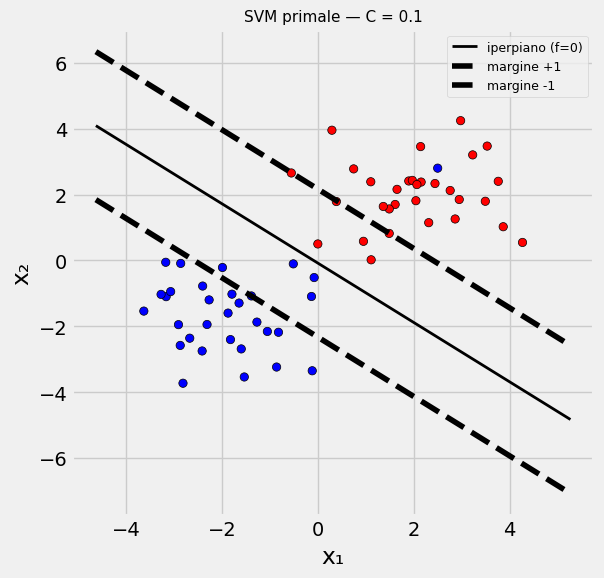

C:	 1.0
epoch    0 | loss=9.4146 | ||w||=1.617
epoch  500 | loss=6.9233 | ||w||=0.820
epoch 1000 | loss=6.8956 | ||w||=0.803


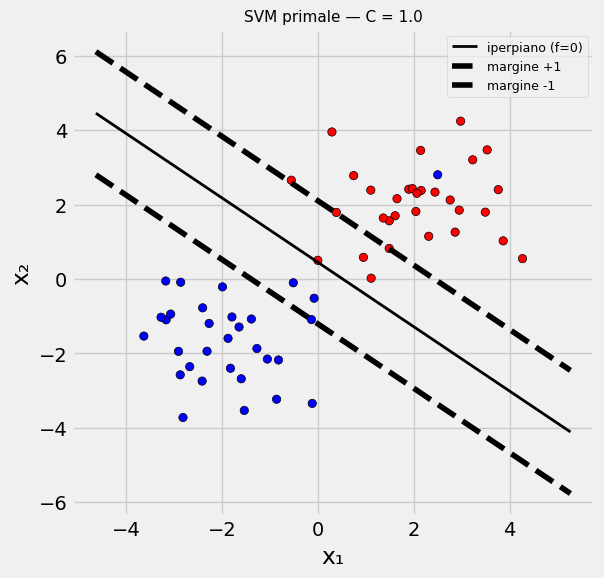

C:	 10.0
epoch    0 | loss=744.9713 | ||w||=16.166
epoch  500 | loss=68.1584 | ||w||=1.002
epoch 1000 | loss=67.5603 | ||w||=0.835


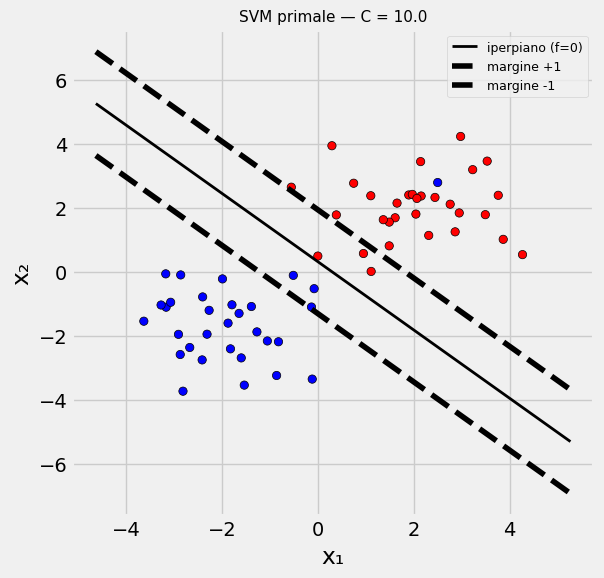

C:	 100.0
epoch    0 | loss=73597.1334 | ||w||=161.662
epoch  500 | loss=36831.4605 | ||w||=90.582
epoch 1000 | loss=11882.9768 | ||w||=29.970


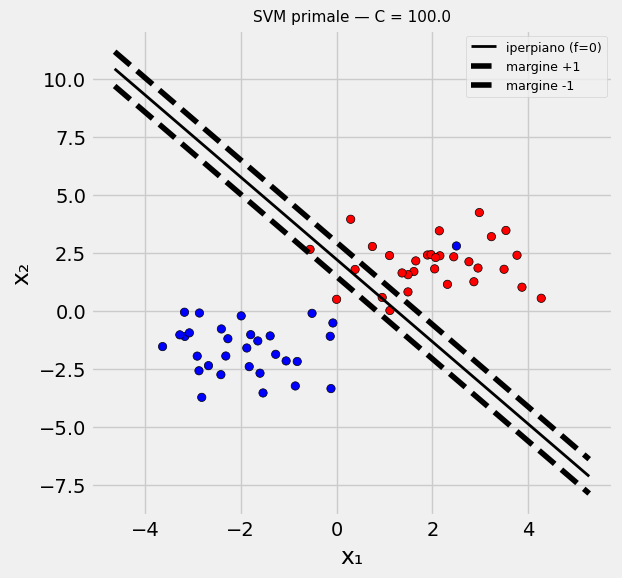

In [ ]:
# ============================================================
# 8) Effetto di C sul margine: confronto visivo
# ============================================================

# Valori di C da confrontare
C_values = [0.1, 1.0, 10.0, 100.0]

for C in C_values:
    print(f"C:\t {C}")
    # Allena una SVM con Batch Subgradient Descent
    w_C, b_C = train_svm_batch_subgradient(
        X, y,
        C=C,
        lr=0.01,
        epochs=1500   # bastano meno iterazioni
    )

    # Ogni plot in una figura separata
    plot_hyperplane(
        w_C, b_C,
        X, y,
        title=f"SVM primale — C = {C}"
    )

    plt.show()

# 4. KKT in pratica: chi sono davvero i Support Vector?

Una delle caratteristiche più eleganti delle SVM è che **non tutti i punti influenzano la soluzione finale**.  
Al contrario, solo una piccola parte dei campioni — i **support vectors** — è responsabile della posizione dell’iperpiano ottimo.

Questa proprietà non è un dettaglio tecnico: è una conseguenza diretta delle condizioni di ottimalità **KKT (Karush–Kuhn–Tucker)** del problema SVM.

---

## 4.1 Complementary Slackness: quando un punto “conta davvero”

Nel **duale** della SVM ogni vincolo è associato a un moltiplicatore di Lagrange $\alpha_i$.  
Le KKT ci dicono:

$$
\alpha_i > 0 \;\;\Longleftrightarrow\;\; t_i\,(w^T x_i + b) = 1
$$

cioè il punto **tocca il margine**.

Viceversa:

$$
\alpha_i = 0 \;\;\Longleftrightarrow\;\; t_i\,(w^T x_i + b) > 1
$$

cioè il punto è **oltre il margine**, ben classificato, e quindi **non influenza** la posizione dell’iperpiano.

Riassumendo:

- **$m_i = t_i f(x_i) > 1$** → punto completamente irrilevante (non un SV)  
- **$m_i = 1$** → punto sul margine → *support vector classico*  
- **$m_i < 1$** → punto dentro il margine o misclassificato → *support vector attivo*

In un’ottica geometrica:  
> Un punto è un support vector **solo se è vicino al confine di decisione**.

---

## 4.2 Nel *primale* non vediamo gli $\alpha_i$… ma vediamo i margini

In questo laboratorio stiamo lavorando nel **primale** tramite subgradient descent.  
In questa formulazione **gli $\alpha_i$ non compaiono**, quindi non possiamo leggerli direttamente.

Ma possiamo utilizzare il **margine funzionale**:

$$
m_i = t_i\,(w^T x_i + b)
$$

che contiene la stessa informazione in forma geometrica.

Interpretazione:

- **$m_i > 1$**  
  Il punto è oltre il margine, non influenza l’ottimo.

- **$m_i \approx 1$**  
  Il punto si trova sul margine → è un vero support vector.

- **$m_i < 1$**  
  Il punto viola il margine o è un errore → influenza pesantemente l’aggiornamento dei pesi.

Questa lettura è perfettamente coerente con le condizioni KKT del duale.

---

## 4.3 Come stimiamo i Support Vector nel primale?

Poiché in pratica il subgradient descent introduce piccole oscillazioni numeriche, useremo una soglia:

$$
m_i \le 1 + \varepsilon
$$

dove $\varepsilon$ è molto piccolo (tipicamente $10^{-3}$).

I punti che soddisfano questa condizione sono considerati **Support Vector stimati**.

Nella prossima cella li visualizziamo rispetto all’iperpiano appreso.

C = 0.1
epoch    0 | loss=3.5996 | ||w||=0.162
epoch  500 | loss=0.8874 | ||w||=0.602
epoch 1000 | loss=0.8873 | ||w||=0.598


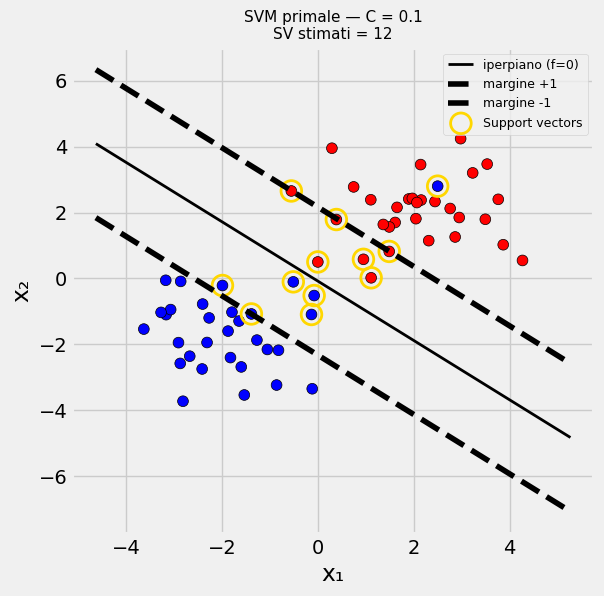

C = 1.0
epoch    0 | loss=9.4146 | ||w||=1.617
epoch  500 | loss=6.9233 | ||w||=0.820
epoch 1000 | loss=6.8956 | ||w||=0.803


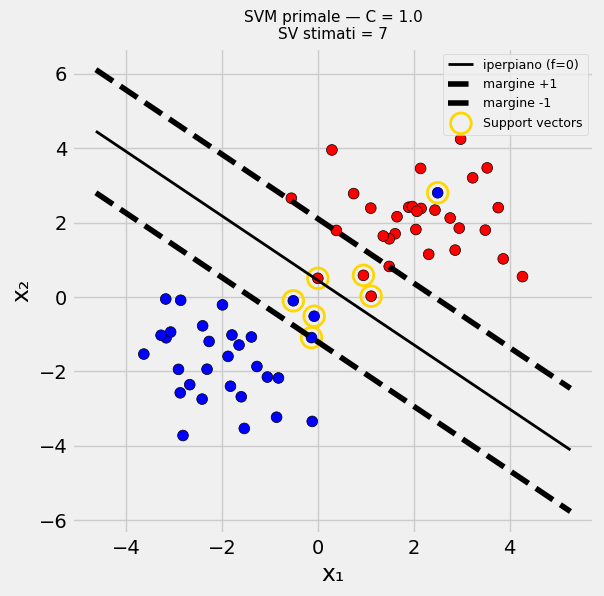

C = 10.0
epoch    0 | loss=744.9713 | ||w||=16.166
epoch  500 | loss=68.1584 | ||w||=1.002
epoch 1000 | loss=67.5603 | ||w||=0.835


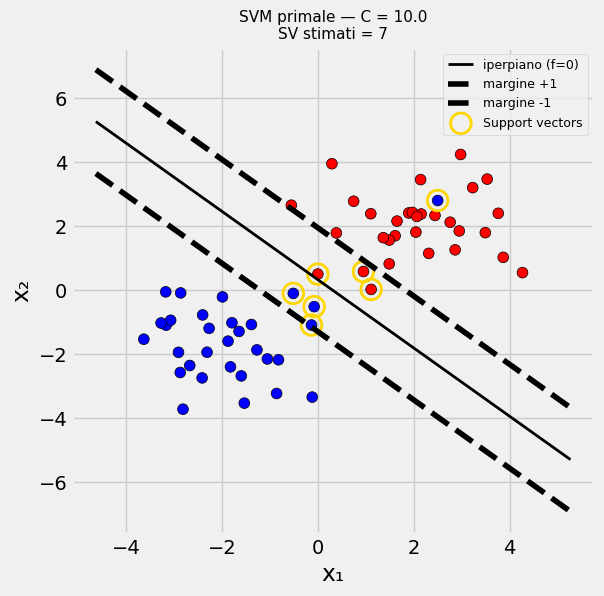

C = 100.0
epoch    0 | loss=73597.1334 | ||w||=161.662
epoch  500 | loss=36831.4605 | ||w||=90.582
epoch 1000 | loss=11882.9768 | ||w||=29.970


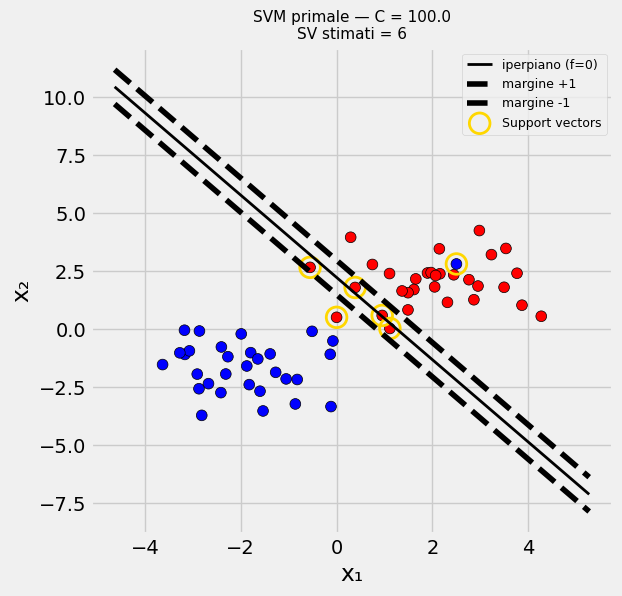

In [ ]:
# ============================================
# Support vectors per diversi valori di C
# ============================================

Cs = [0.1, 1.0, 10.0, 100.0]   # morbido → medio → rigido
epsilon = 1e-3                 # tolleranza numerica

for C in Cs:

    print("C =", C)

    # Allena SVM primale (subgradient descent)
    w_C, b_C = train_svm_batch_subgradient(
        X, y, C=C, lr=0.01, epochs=1500
    )

    # Margini funzionali
    margins = y * (X @ w_C + b_C)

    # Support vector stimati (nel primale)
    sv = margins <= (1 + epsilon)

    # ---- nuova figura pulita ----
    plot_hyperplane(
        w_C, b_C, X, y,
        title=f"SVM primale — C = {C}\nSV stimati = {sv.sum()}"
    )

    # Punti del dataset sopra l'iperpiano
    plt.scatter(
        X[:,0], X[:,1], c=y,
        cmap="bwr", edgecolor="k", s=60
    )

    # Evidenzia support vectors
    plt.scatter(
        X[sv, 0], X[sv, 1],
        s=220, facecolors='none', edgecolors='gold', linewidths=2,
        label="Support vectors"
    )

    plt.legend(fontsize=9)
    plt.show()

### 📝 Takeaway (KKT → chi “conta” davvero)

Definiamo il margine funzionale:
$$
m_i = t_i f(x_i) = t_i(w^T x_i + b).
$$

- Se $m_i > 1$: il punto è corretto e **fuori dal margine**  
  $\Rightarrow$ in genere $\alpha_i = 0$ $\Rightarrow$ **non è un support vector** (non influenza la soluzione).

- Se $m_i = 1$: il punto è **sul margine**  
  $\Rightarrow$ tipicamente $0 < \alpha_i < C$ $\Rightarrow$ **support vector “classico”**.

- Se $m_i < 1$: il punto è **dentro il margine** (oppure misclassificato)  
  $\Rightarrow$ tipicamente $\alpha_i = C$ e $\xi_i > 0$ $\Rightarrow$ **support vector “attivo”**.

Quindi, nel **soft margin**, i support vector non sono solo quelli “sul bordo”:
includono anche le **violazioni** ($m_i<1$).  
Nel duale, la soluzione è sparsa perché solo i punti con $\alpha_i>0$ contribuiscono a
$$
w = \sum_i \alpha_i t_i x_i.
$$

> Nota: nell’“hard margin” (dati separabili) tipicamente i support vector stanno sul margine ($m_i=1$).
> Con rumore/outlier (soft margin) compaiono anche support vector con $m_i<1$.

---

# 5. Confronto con una SVM vera (Linear SVM di scikit-learn)

Ora vediamo come si comporta `LinearSVC`, che è un'implementazione ottimizzata della stessa SVM **nel primale**.

Confronteremo:

- boundary  
- support vectors  
- margini  

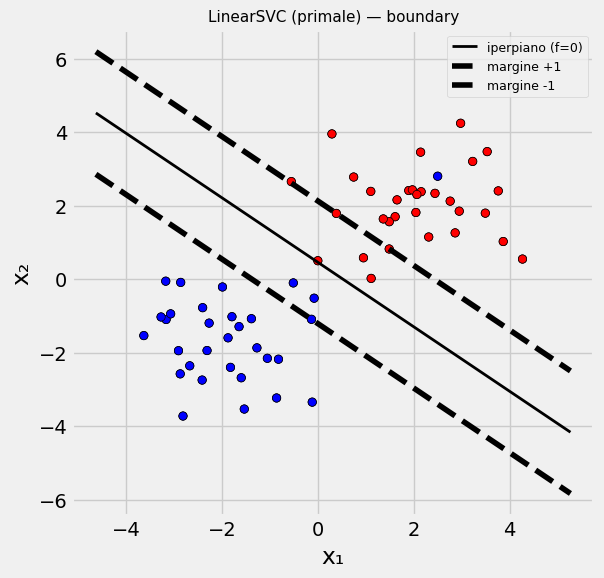

In [ ]:
from sklearn.svm import LinearSVC

clf = LinearSVC(C=1.0, loss="hinge")
clf.fit(X, y)

w_lin = clf.coef_.ravel()
b_lin = clf.intercept_[0]

# plot_hyperplane crea già una figura pulita
plot_hyperplane(
    w_lin, b_lin, X, y,
    title="LinearSVC (primale) — boundary"
)

# aggiungo i punti sopra la linea
plt.scatter(
    X[:,0], X[:,1],
    c=y, cmap='bwr', edgecolor='k'
)

plt.legend(fontsize=9)
plt.show()

### Confronto qualitativo:

- Il boundary è praticamente lo stesso del nostro metodo iterativo.  
- I support vectors identificati via margini sono molto simili.  
- LinearSVC è più stabile e veloce, ma segue lo *stesso obiettivo*.

---

# 6. Dal primale al duale: perché servono i kernel

Finora abbiamo lavorato nel **primal**, con parametri $w\in\mathbb{R}^d$.  
Questo funziona bene, **ma solo in spazi lineari**.

Per separare dati non linearmente separabili, serve il **duale**.

## 6.1 Il duale a grandi linee

Nel duale, la SVM dipende solo da **prodotti scalari**:

$$
K(x_i,x_j) = x_i^T x_j
$$

Sostituendo:

$$
x_i^T x_j \;\to\; K(x_i,x_j)
$$

possiamo lavorare in spazi trasformati $\phi(x)$ **senza calcolare $\phi$**.

Questa è la magia del **kernel trick**.

---

## 6.2 Kernel comuni

- **Lineare**:  
  $K(x,y)=x^Ty$

- **Polinomiale**:  
  $K(x,y) = (x^Ty + c)^p$

- **RBF / Gaussian**:  
  $K(x,y) = \exp(-\gamma \|x-y\|^2)$

- **Sigmoide**:  
  $K(x,y)=\tanh(\alpha x^Ty + c)$

---

Ora mostriamo un esempio visivo con un dataset **non lineare**.

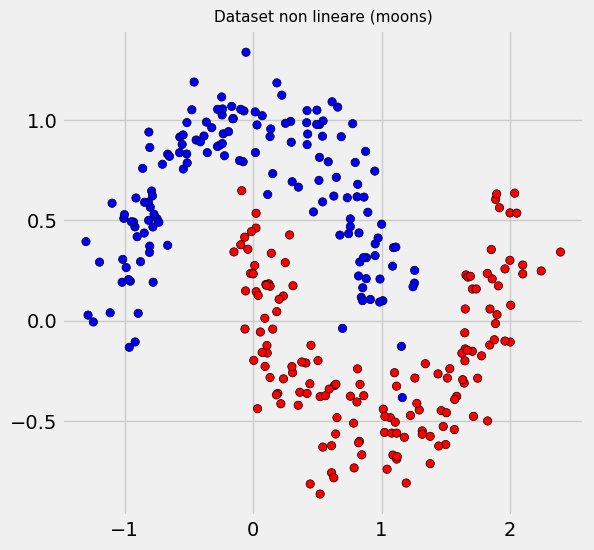

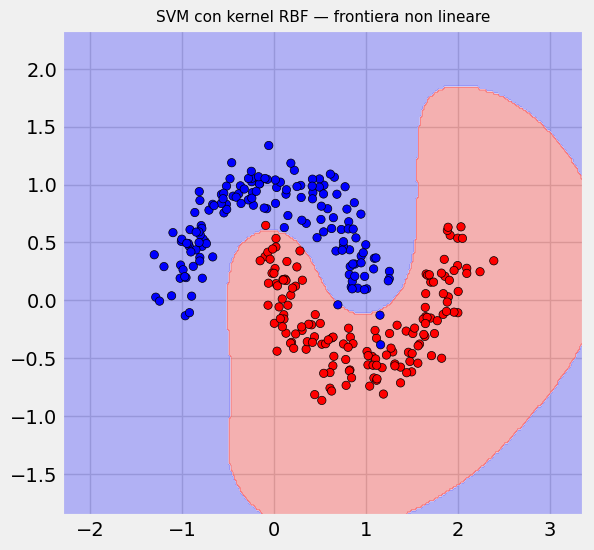

In [ ]:
# ============================================
# 9) Dataset non lineare (moons)
# ============================================

from sklearn.datasets import make_moons
from sklearn.svm import SVC

# Dataset non lineare
X2, y2 = make_moons(n_samples=300, noise=0.15, random_state=0)
y2 = 2*y2 - 1   # converti {0,1} → {-1,+1}

plt.figure()
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap='bwr', edgecolor='k')
plt.title("Dataset non lineare (moons)", fontsize=11)
plt.grid(True)
plt.show()

# SVM con kernel RBF
clf_rbf = SVC(kernel='rbf', C=1.0, gamma=2.0)
clf_rbf.fit(X2, y2)

# Plot della decision boundary
h = 0.02
xx, yy = np.meshgrid(
    np.arange(X2[:,0].min()-1, X2[:,0].max()+1, h),
    np.arange(X2[:,1].min()-1, X2[:,1].max()+1, h)
)
Z = clf_rbf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, alpha=0.3, cmap='bwr')
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap="bwr", edgecolor='k')
plt.title("SVM con kernel RBF — frontiera non lineare", fontsize=11)
plt.grid(True)
plt.show()

### 📝 Takeaway finale

- Il **primal** è ottimo quando:
  - le feature sono molte (alto d),
  - i dati sono tanti (alto n),
  - non servono kernel → decisioni lineari.

- Il **duale** è necessario quando:
  - vuoi usare kernel,
  - vuoi separazioni non lineari,
  - n è moderato (< 10k).

- Il kernel trick trasforma SVM in un classificatore **non lineare potente**  
  senza calcolare mai lo spazio \(\phi(x)\).

- Gli **support vector** sono l’essenza geometrica delle SVM:  
  pochi punti determinano il classificatore.

---

# ✔ Fine del notebook — Suggerimenti

- Prova a cambiare C e osservare chi diventa support vector.  
- Prova kernel polinomiale viola: \(p=5\).  
- Prova il metodo iterativo con learning rate decrescente.

---

# Approfondimento

Il modello SVM lineare ha forma:

$$
f(x)=w^T x + b
\qquad
w=\sum_{i\in SV} \alpha_i t_i x_i
$$

Nel duale compaiono solo i **support vector**, perciò w non dipende da tutti i dati,
ma solo dalla combinazione lineare dei punti "attivi" (quelli sul margine o violazioni).

Il codice mostra che il w ricostruito dalla formula del duale coincide esattamente
con quello restituito da scikit-learn.

Support Vector indices: [42 54 10 16]

Support Vectors:
  index= 42,  x=[-0.51174781 -0.10411082]
  index= 54,  x=[-0.07705797 -0.51948521]
  index= 10,  x=[-0.55298982  2.6536186 ]
  index= 16,  x=[1.11221425 0.01920353]

Labels dei SV (t_i): [-1. -1.  1.  1.]

α_i * t_i dal duale: [-0.06729469 -1.          0.07426815  0.99302654]

Coefficiente duale α_i reale: [0.06729469 1.         0.07426815 0.99302654]

w ricostruito a mano: [1.17488463 0.74264027]
w da sklearn       : [1.17488463 0.74264027]

b ricostruito a mano: -0.3717707868190526
b da sklearn        : -0.32113600303442774


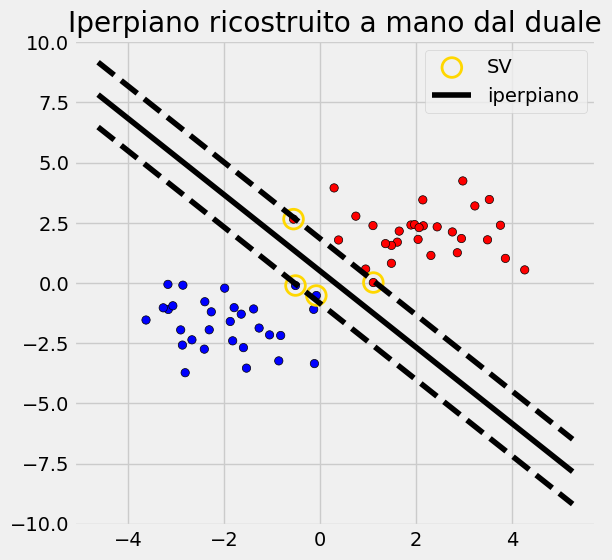

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# =============================
# 1) Dataset 2D semplice
# =============================
np.random.seed(0)
N = 30
X_pos = np.random.randn(N, 2) + np.array([2, 2])
X_neg = np.random.randn(N, 2) + np.array([-2, -2])
X = np.vstack([X_pos, X_neg])
y = np.hstack([np.ones(N), -np.ones(N)])

# =============================
# 2) Addestriamo una SVM lineare (DUALE)
# =============================
clf = SVC(kernel='linear', C=1.0)
clf.fit(X, y)

# =============================
# 3) Estraiamo TUTTO in chiaro
# =============================

# indici dei support vector
sv_idx = clf.support_
print("Support Vector indices:", sv_idx)

# support vector veri e propri
sv = clf.support_vectors_
print("\nSupport Vectors:")
for i, v in zip(sv_idx, sv):
    print(f"  index={i:3d},  x={v}")

# etichette t_i dei support vector
sv_labels = y[sv_idx]
print("\nLabels dei SV (t_i):", sv_labels)

# coefficienti duali αᵢ tᵢ (come forniti da sklearn)
dual_coef = clf.dual_coef_[0]
print("\nα_i * t_i dal duale:", dual_coef)

# Calcolo αᵢ veri:
alpha = dual_coef / sv_labels
print("\nCoefficiente duale α_i reale:", alpha)

# =============================
# 4) Ricostruiamo w a mano
# =============================
w_manual = np.sum(dual_coef[:,None] * sv, axis=0)

print("\nw ricostruito a mano:", w_manual)
print("w da sklearn       :", clf.coef_.ravel())

# =============================
# 5) Ricostruiamo b a mano
# =============================
b_candidates = sv_labels - np.dot(sv, w_manual)
b_manual = np.mean(b_candidates)

print("\nb ricostruito a mano:", b_manual)
print("b da sklearn        :", clf.intercept_[0])


# =============================
# 6) Funzione per plottare l'iperpiano
# =============================
def plot_hyperplane(w, b, X, y, support_vectors, title):
    plt.figure(figsize=(6,6))

    # Punti
    plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolor='k')

    # Evidenzia SV
    plt.scatter(
        support_vectors[:,0], support_vectors[:,1],
        s=200, facecolors='none', edgecolors='gold',
        linewidths=2, label="SV"
    )

    # Iperpiano
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    xs = np.linspace(x_min, x_max, 200)
    ys = -(w[0]*xs + b)/w[1]

    ys_pos = -(w[0]*xs + b - 1)/w[1]
    ys_neg = -(w[0]*xs + b + 1)/w[1]

    plt.plot(xs, ys, 'k', label="iperpiano")
    plt.plot(xs, ys_pos, 'k--')
    plt.plot(xs, ys_neg, 'k--')

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# =============================
# 7) Plot finale del duale
# =============================
plot_hyperplane(
    w_manual, b_manual, X, y, sv,
    title="Iperpiano ricostruito a mano dal duale"
)

# 📎 Appendice — Teoria di Vapnik: perché il massimo margine riduce l’errore su dati futuri

L’idea centrale delle SVM non nasce dalla geometria, ma dalla teoria della **generalizzazione** sviluppata da Vapnik.  
Un modello non deve solo funzionare sul training, ma controllare l’**errore vero** (su nuovi dati non osservati).

Questa appendice sintetizza il contributo teorico: **come il margine controlla la complessità del modello** (capacity) e quindi l’errore futuro.

---

# 1️⃣ Errore empirico vs errore di generalizzazione

Per un classificatore $h$ definiamo:

- **errore empirico**
  $$
  L_{\text{emp}}(h) = \frac{1}{n}\sum_{i=1}^n \mathbf{1}\{h(x_i)\neq t_i\}
  $$
- **errore vero**
  $$
  L(h)=\mathbb{P}_{(x,t)\sim\mathcal{D}}[\,h(x)\neq t\,]
  $$

Il problema del ML è che $L(h)$ non è osservabile:  
vogliamo garantire che sia *vicino* a $L_{\text{emp}}(h)$.

La teoria di Vapnik mostra che questo è possibile solo se si controlla la **complessità** della classe di funzioni $H$.

---

# 2️⃣ Il bound fondamentale: errore vero = errore empirico + complessità

Con alta probabilità (dipendente da $n$), vale un bound del tipo:

$$
L(h)
\;\le\;
L_{\text{emp}}(h)
\;+\;
\sqrt{\frac{h_{\text{VC}}(H)\,\log(n) - \log(\delta)}{n}}
$$

dove:

- $h_{\text{VC}}(H)$ è la **VC-dimension** della famiglia di classificatori,
- il secondo termine è il **termine di complessità** (capacity term).

Interpretazione:

- se $h_{\text{VC}}(H)$ è grande → rischio di overfitting  
- controllare la complessità → migliora la garanzia sull’errore futuro

Il principio che ne deriva è il cuore della statistica di Vapnik:
> **Structural Risk Minimization = minimizzare errore empirico + complessità**.

---

# 3️⃣ Classificatori lineari: il ruolo del margine

Per classificatori lineari in $\mathbb{R}^d$, la VC-dimension è tipicamente $d$,  
ma Vapnik mostra che, **quando si considera un margine geometrico $\gamma$**, vale un bound più fine.

Sia:
- $R$ il raggio minimo di una sfera che contiene tutti i dati,
- $\gamma$ il margine geometrico dell’iperpiano trovato.

Allora esiste un bound del tipo:

$$
h_{\text{VC}} \;\lesssim\; \left(\frac{R}{\gamma}\right)^2.
$$

Interpretazione chiave:

- $R$ è fissato dai dati,  
- ma $\gamma$ dipende dal classificatore scelto.

Quindi:

- **margine grande** ($\gamma$ grande) ⇒ complessità minore ⇒ migliore generalizzazione  
- **margine piccolo** ⇒ classificatore più complesso ⇒ maggiore rischio overfitting

Questa è la motivazione teorica del principio SVM:
> **massimizzare il margine = controllare la complessità del modello**.

---

# 4️⃣ Soft margin: $C$ come controllo del compromesso capacità / errore

Nel soft margin SVM la funzione obiettivo è:

$$
\min_{w,b}\;\frac{1}{2}\|w\|^2 \;+\; C \sum_{i=1}^n \max(0,\, 1 - t_i(w^\top x_i + b))
$$

dove:

- il termine $\frac12 \|w\|^2$ impone un grande margine → **riduce la capacity**  
- la hinge loss penalizza violazioni del margine → **riduce l’errore empirico**  
- $C$ bilancia i due effetti

Interpretazione ML:

- $C$ grande ⇒ si riduce il training error, ma può diminuire il margine ⇒ capacity alta  
- $C$ piccolo ⇒ margine più ampio, capacity più bassa ⇒ modello più robusto

È esattamente l’implementazione pratica del principio di **Structural Risk Minimization**.

---

# 5️⃣ Perché pochi punti (support vectors) determinano la soluzione

Nel duale della SVM la soluzione ha la forma:

$$
w = \sum_{i=1}^n \alpha_i t_i x_i
$$

con vincoli:

- $\alpha_i = 0$ per punti **fuori dal margine**  
- $\alpha_i > 0$ solo per punti **sul margine** o **dentro il margine**

Le condizioni KKT implicano che la soluzione è **sparsa**:  
solo i punti critici determinano il confine di decisione.

Dal punto di vista della capacity:
- meno libertà effettiva → modello più controllato  
- concentrazione solo sulle regioni di incertezza → generalizzazione più stabile

---

# 6️⃣ Takeaway (formale ma operativo)

1. Vapnik dimostra che l’errore su dati futuri è controllato da  
   $$L_{\text{emp}} + \text{capacity}(H).$$

2. Per classificatori lineari, la capacity cala quando **il margine aumenta**.

3. Le SVM massimizzano il margine ⇒ **minimal capacity** tra i separatori possibili.

4. La soft margin SVM realizza il compromesso “errore vs complessità” tramite $C$.

5. La sparsità dei support vector è una conseguenza naturale della teoria di ottimalità (KKT), non un effetto numerico.

In sintesi:

> **Le SVM sono un’implementazione concreta del principio di Structural Risk Minimization:  
> minimizzare l’errore mantentendo sotto controllo la complessità del modello.**  

# 🔮 7. Confronto visivo dei Kernel: Lineare, Polinomiale, RBF, Sigmoide

Finora abbiamo visto come funziona la SVM **nel primale** e perché il duale permette
di usare i kernel.

Ora vogliamo una cosa semplice ma potentissima:

> **Guardare come cambia la frontiera di decisione usando kernel diversi**
> sullo *stesso* dataset non lineare.

Confronteremo i kernel standard:

### 1️⃣ Lineare  
Iperpiano. Non può curvare.

### 2️⃣ Polinomiale (Poly)  
Permette frontiere curve di complessità crescente.  
Il parametro chiave è il grado `degree`.

### 3️⃣ RBF (Gaussian)  
Frontiera molto flessibile.  
Il parametro chiave è `gamma`, che controlla quanto ogni punto influenza il confine.

### 4️⃣ Sigmoide (tanh)  
Simile a un neurone di una rete neurale:  
$$ K(x,y) = \tanh(\alpha x^T y + c) $$
Non sempre dà una separazione pulita, ma è istruttivo vederlo.

---

## 🎯 Obiettivo della cella seguente

- Generare un dataset “moons” non lineare.
- Addestrare 4 SVM con kernel diversi.
- Mostrare 4 grafici comparativi delle decision boundary.

Vedremo visivamente quale kernel è in grado di “seguire” meglio la vera forma del dato.

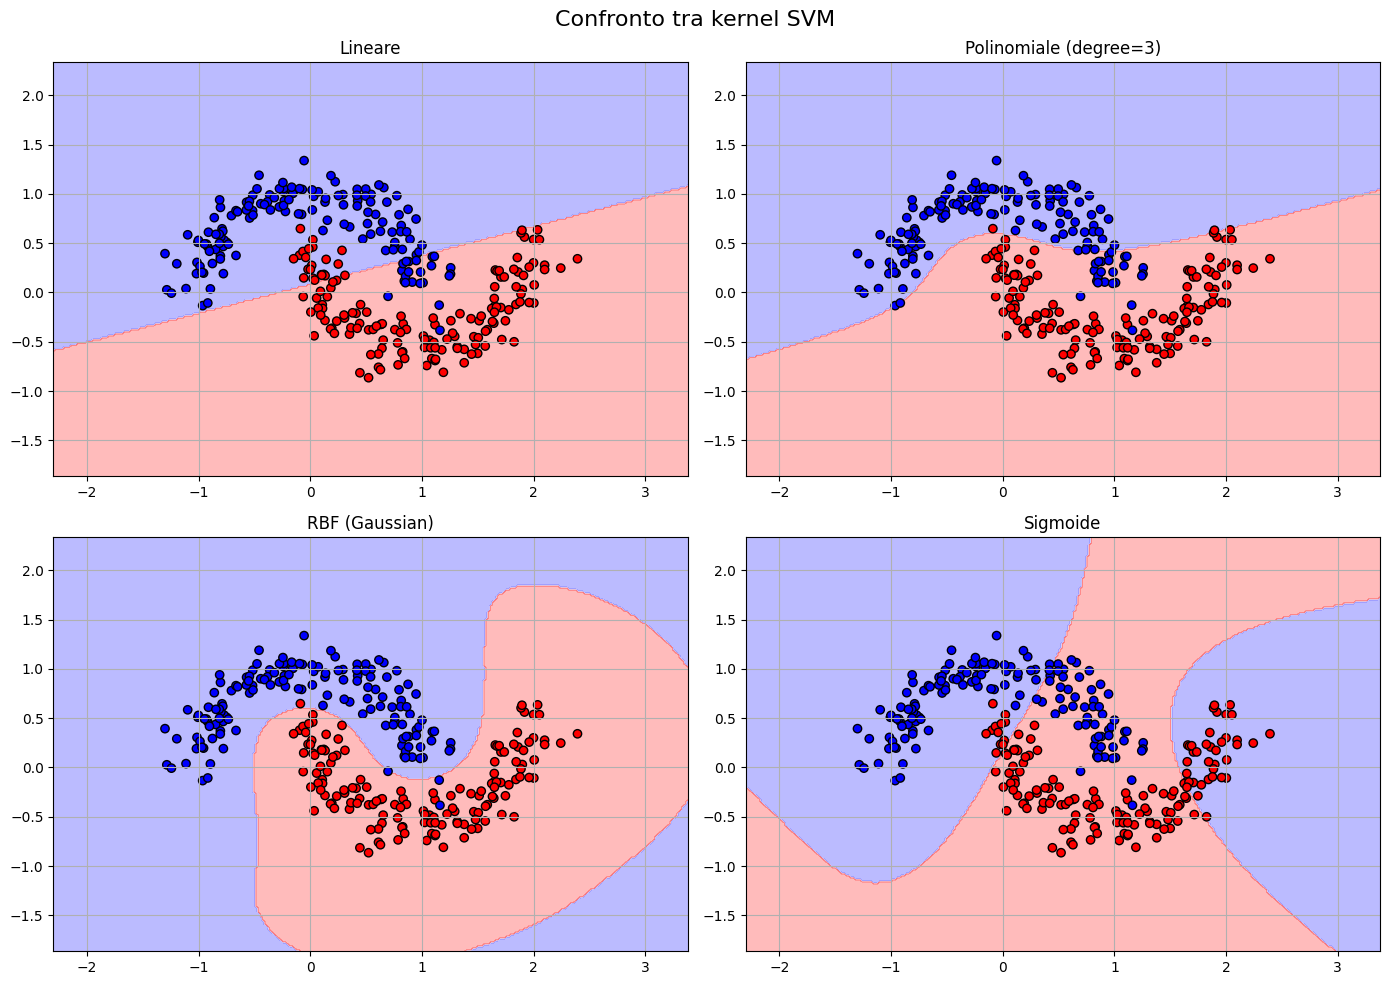

In [ ]:
# ============================================================
# 7) Confronto visivo dei kernel su un dataset non lineare
# ============================================================

from sklearn.svm import SVC
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt

# Dataset 2D non lineare
Xk, yk = make_moons(n_samples=300, noise=0.15, random_state=0)
yk = 2*yk - 1    # converti da {0,1} a {-1,+1}

kernels = [
    ("Lineare",   SVC(kernel="linear", C=1.0)),
    ("Polinomiale (degree=3)", SVC(kernel="poly", degree=3, C=1.0)),
    ("RBF (Gaussian)", SVC(kernel="rbf", gamma=2.0, C=1.0)),
    ("Sigmoide",  SVC(kernel="sigmoid", coef0=1.0, C=1.0))
]

# Grid per la decision boundary
h = 0.02
x_min, x_max = Xk[:, 0].min() - 1, Xk[:, 0].max() + 1
y_min, y_max = Xk[:, 1].min() - 1, Xk[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)

plt.figure(figsize=(14, 10))

for i, (title, model) in enumerate(kernels, 1):
    # Addestra il modello
    model.fit(Xk, yk)

    # Predici sulla griglia
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    plt.subplot(2, 2, i)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="bwr")
    plt.scatter(Xk[:, 0], Xk[:, 1], c=yk, cmap="bwr", edgecolor="k")
    plt.title(title)
    plt.grid(True)

plt.suptitle("Confronto tra kernel SVM", fontsize=16)
plt.tight_layout()
plt.show()

# 📘 Interpretazione dei diversi kernel SVM

La figura precedente confronta il comportamento di alcuni tra i kernel più utilizzati nelle Support Vector Machines.  
Sebbene l’algoritmo SVM sia lo stesso in tutti i casi, la scelta del kernel modifica in modo sostanziale la geometria dello spazio delle feature, e quindi la forma della frontiera di decisione.

Di seguito una lettura comparativa dei risultati ottenuti.

---

## 1. Kernel lineare
Il kernel lineare mantiene la geometria originaria dello spazio: le classi vengono separate da un **iperpiano** (in 2D: una retta).  
Il modello cattura solo separazioni grossolanamente lineari.  

### Interpretazione
Il prodotto scalare \( x^\top y \) misura unicamente l’allineamento tra i vettori; la nozione di “somiglianza” è quindi puramente direzionale.  
Se la struttura intrinseca dei dati è curva o complessa, il kernel lineare non può adattarsi, e la frontiera risulta necessariamente lineare, come osservato nella figura.

---

## 2. Kernel polinomiale (grado 3)
Il kernel polinomiale introduce interazioni non lineari tra le feature, consentendo di modellare **curve globali**.  
Rispetto al lineare, la frontiera segue meglio l’andamento dei dati, ma rimane relativamente “liscia”: il polinomio impone una curvatura globale e controllata.

### Interpretazione
La funzione di similitudine  
\[
K(x,y) = (x^\top y + c)^p
\]
mappa i dati in uno spazio dove appaiono naturali relazioni non lineari fino al grado \(p\).  
La frontiera risultante riflette tale struttura: flessibile, ma non arbitrariamente locale.

---

## 3. Kernel RBF (Gaussian)
Il kernel RBF è il più flessibile tra quelli mostrati.  
Esso basa la nozione di somiglianza sulla **prossimità locale**: punti molto vicini sono considerati fortemente simili, mentre punti lontani sono quasi ortogonali nello spazio trasformato.

### Interpretazione
Il termine  
\[
K(x,y)=\exp(-\gamma\|x-y\|^2)
\]
crea attorno a ciascun punto una regione di influenza locale (una “bolla gaussiana”).  
La SVM separa linearmente nello spazio indotto dal kernel, ma nel piano originale ciò si traduce in frontiere altamente non lineari, capaci di seguire in modo preciso le pieghe del dataset.  
È il motivo per cui l’RBF rappresenta in genere la scelta più potente in scenari non linearmente separabili.

---

## 4. Kernel sigmoide
Il kernel sigmoide deriva dalla funzione di attivazione delle reti neurali:  
\[
K(x,y)=\tanh(\alpha x^\top y + c).
\]
Il comportamento risultante è meno regolare rispetto al polinomiale o all’RBF: la frontiera può apparire localmente distorta o sbilanciata.

### Interpretazione
La non linearità introdotta dal termine di tipo neurale può produrre regioni di decisione complesse, ma anche fenomeni di saturazione (la tangente iperbolica appiattisce le distanze per valori estremi).  
Ne risulta una geometria della decisione meno prevedibile e spesso più difficile da controllare, come mostrato nella figura.

---

## Conclusione
Il comportamento osservato dipende interamente dalla **nozione di somiglianza** definita dal kernel.  
La SVM opera sempre tramite un iperpiano nello spazio trasformato; è la trasformazione indotta dal kernel che determina la complessità visibile nel piano originale.

In breve:

| Kernel | Tipo di trasformazione | Forma della frontiera |
|--------|--------------------------|------------------------|
| Lineare | nessuna | retta (iperpiano) |
| Polinomiale | curvatura globale | curva liscia, controllata |
| RBF | prossimità locale | frontiera molto flessibile |
| Sigmoide | attivazione tipo neurale | curvatura irregolare |

La scelta del kernel non modifica l’algoritmo SVM, ma cambia lo **spazio geometrico** in cui la separazione avviene.  
Comprendere questa relazione è essenziale per motivare scelte informate nella progettazione di modelli non lineari.